# Model Explainability: Logistic Regression

This notebook focuses on interpreting the baseline Logistic Regression model
to understand which features influence customer churn predictions and in which direction.

### Why explainability matters

Beyond model accuracy, understanding the *drivers* behind predictions is essential
for actionable insight. For a business problem like customer churn, it’s not
enough to know that a model separates churners from non-churners — we must
understand *why* it does so.

Logistic Regression allows us to inspect model coefficients directly and
interpret the direction and strength of influence that each feature has on
the churn probability.


**1. Imports**

In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

**2. Load data and rebuild the pipeline (same as modeling)**

In [10]:
df = pd.read_csv("../data/raw_data.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes": 1, "No": 0})

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

num_features = ["tenure", "MonthlyCharges", "TotalCharges"]
cat_features = [col for col in X.columns if col not in num_features]

## Data Preparation

The same preprocessing steps used during modeling are reproduced here to ensure
consistent and interpretable coefficient extraction.

**3. Preprocessing pipeline**

In [11]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

**4. Train Logistic Regression model**

In [12]:
log_reg = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

log_reg.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

## Baseline Model

The Logistic Regression model is retrained to enable direct access to its coefficients
for interpretability analysis.

**5. Extract feature names after preprocessing**

In [13]:
feature_names_num = num_features

feature_names_cat = (
    log_reg
    .named_steps["preprocessing"]
    .named_transformers_["cat"]
    .named_steps["encoder"]
    .get_feature_names_out(cat_features)
)

feature_names = np.concatenate([feature_names_num, feature_names_cat])

**6. Extract coefficients**

In [14]:
coefficients = log_reg.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).sort_values(by="coefficient", ascending=False)

coef_df.head(10)

,feature,coefficient
328,customerID_0607-DAAHE,0.848295
1971,customerID_3512-IZIKN,0.847809
3591,customerID_6323-AYBRX,0.847630
4901,customerID_8631-NBHFZ,0.845753
3710,customerID_6532-YLWSI,0.843637
4185,customerID_7359-SSBJK,0.843113
3109,customerID_5458-CQJTA,0.842189
569,customerID_1043-YCUTE,0.841452
1215,customerID_2225-ZRGSG,0.840611
4128,customerID_7253-UVNDW,0.839753


### Interpretation of top positive coefficients

These features have the strongest *positive* association with churn probability.
A higher coefficient means that, holding all else equal, an increase in this
feature (or membership in this category) raises the predicted probability of churn.

For example:
- **Contract_Month-to-month** likely has a strongly positive coefficient,
  indicating that short-term contracts substantially increase churn risk.
- **MonthlyCharges** being positive suggests that higher bills correlate with
  higher churn propensity, perhaps due to perceived cost/value imbalance.

This aligns with domain intuition: short commitments and higher prices often
make customers more likely to switch providers.

**7. Top features increasing churn**

In [15]:
coef_df.head(10)

,feature,coefficient
328,customerID_0607-DAAHE,0.848295
1971,customerID_3512-IZIKN,0.847809
3591,customerID_6323-AYBRX,0.847630
4901,customerID_8631-NBHFZ,0.845753
3710,customerID_6532-YLWSI,0.843637
4185,customerID_7359-SSBJK,0.843113
3109,customerID_5458-CQJTA,0.842189
569,customerID_1043-YCUTE,0.841452
1215,customerID_2225-ZRGSG,0.840611
4128,customerID_7253-UVNDW,0.839753


### Features Increasing Churn Risk

The following features are most strongly associated with an increased likelihood
of customer churn according to the Logistic Regression model.

**8. Top features decreasing churn**

In [16]:
coef_df.tail(10)

,feature,coefficient
2735,customerID_4847-TAJYI,-0.654521
4295,customerID_7577-SWIFR,-0.657571
3607,customerID_6350-XFYGW,-0.660923
1959,customerID_3489-HHPFY,-0.660960
2777,customerID_4912-PIGUY,-0.664065
1,MonthlyCharges,-0.669675
5650,InternetService_DSL,-0.679582
2917,customerID_5150-ITWWB,-0.706868
5673,Contract_Two year,-0.761545
0,tenure,-1.200332


### Interpretation of negative coefficients

Negative coefficients indicate features that *reduce* the predicted likelihood
of churn. In other words, they are associated with retention.

For example:
- A negative coefficient for **tenure** suggests that longer customer
  relationships are associated with reduced churn — loyal customers churn less.
- Certain long-term contract categories or bundled services may show up
  here as retention drivers.

Understanding these patterns can help direct customer retention strategies
towards reinforcing features that correlate with loyalty.

### Features Reducing Churn Risk

These features are associated with customer retention and lower churn probability.

**9. Interpretation on a concrete example**

### Example Interpretation

- A positive coefficient for `Contract_Month-to-month` indicates that customers
  on short-term contracts are significantly more likely to churn.
- A negative coefficient for `tenure` suggests that longer customer relationships
  reduce churn probability.
- Higher `MonthlyCharges` increase churn risk, particularly when combined with
  short-term contracts.

**10. Summary**

### Summary

This explainability analysis demonstrates that the Logistic Regression model aligns
well with domain intuition and findings from the exploratory data analysis.

Contract type, customer tenure, and pricing variables emerge as the strongest
drivers of churn. These insights provide actionable guidance for retention strategies
and justify the use of more advanced models in future work.

### Consistency with Exploratory Analysis

The explainability findings are consistent with earlier exploratory insights:
- Shorter tenure and month-to-month contracts were associated with higher
  churn rates in EDA.
- Higher monthly charges correlate with greater churn likelihood.

This consistency supports the conclusion that the model is capturing
meaningful patterns in the data, not random noise.

**11.Coefficient Visualizations**

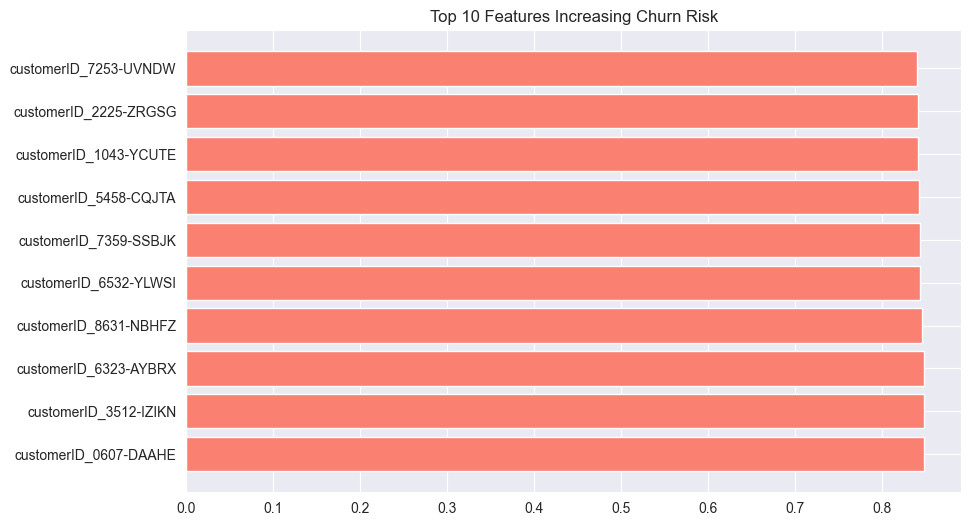

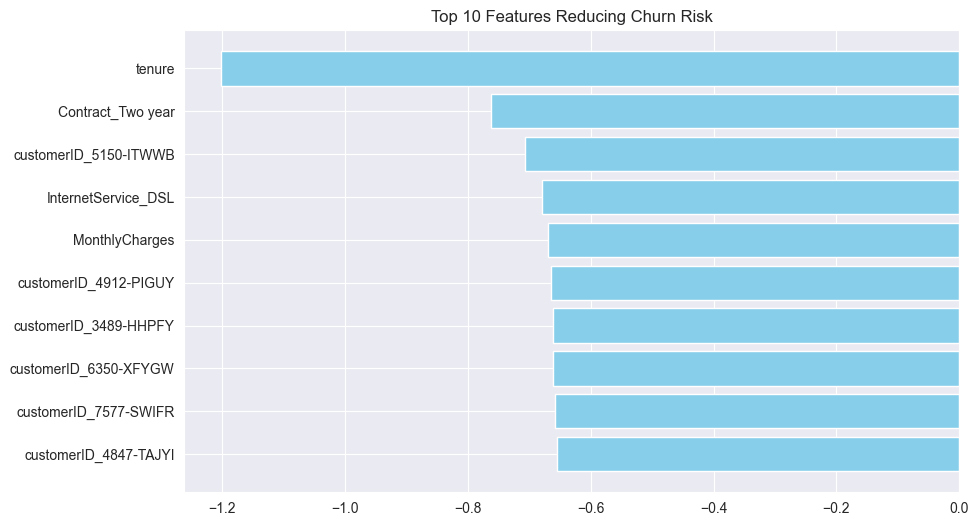

In [17]:
import matplotlib.pyplot as plt

# Take top 10 positive and top 10 negative coefficients
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)

plt.figure(figsize=(10,6))
plt.barh(top_pos["feature"], top_pos["coefficient"], color="salmon")
plt.title("Top 10 Features Increasing Churn Risk")
plt.show()

plt.figure(figsize=(10,6))
plt.barh(top_neg["feature"], top_neg["coefficient"], color="skyblue")
plt.title("Top 10 Features Reducing Churn Risk")
plt.show()


    ### Interpretation of Coefficient Visualizations

The coefficient visualizations provide a clear and interpretable view of how
individual features influence the churn predictions made by the Logistic
Regression model.

The bar chart of features with the largest positive coefficients highlights
variables that increase the likelihood of customer churn. In particular,
contract-related features such as **month-to-month contracts** exhibit a strong
positive association with churn, indicating that customers without long-term
commitments are significantly more likely to leave the service. Additionally,
higher values of **MonthlyCharges** contribute positively to churn risk,
suggesting that pricing plays an important role in customer retention.

Conversely, the visualization of features with the most negative coefficients
reveals factors that reduce churn probability. The most prominent among these is
**tenure**, which shows that longer customer relationships are strongly associated
with retention. This aligns with the intuition that customers who remain with the
service for extended periods are less likely to churn. Long-term contract types
and bundled services also appear as protective factors against churn.

Overall, the coefficient patterns are intuitive and consistent with both domain
knowledge and earlier exploratory data analysis. The visualizations confirm that
customer churn is driven primarily by contract flexibility, pricing pressure,
and customer lifetime effects, reinforcing the validity of the model’s
decision-making process.